# Business Understanding

## Overview 
The dataset we chose contains car evaluation data derived from a hierarchical decision model developed initially for a demonstration of a decision making model and can be found at [[1]](#footnote1). The authors The dataset contains 6 attributes related to either price or technical characteristics. The 7th attribute represents the estimated class of the car and is based on all other attributes. The dataset consists of 1728 entries and is stripped of structural attributes, which means all attributes are directly related to the estimated car class attribute. There are also three intermediate attributes – PRICE, TECH and COMFORT – which are related to the 6 main attributes. 
## Use case
Choosing a vehicle to purchase can be a tedious process that involves hours of research, with studies showing American drivers spend an average of around 15 hours between realizing the need for a new car and making the purchase [[2]](#footnote2). 60% of this time is usually spent in online research of specifications and availability. Generally, although the most important attribute of a car is its ability to transport, the final decision is very often based on an amalgam of its price, safety and capacity. The main purpose for the collection of the dataset we chose was to “actively support the decision maker in the knowledge acquisition and evaluation stages of the decision making process” [[3]](#footnote3). 

Furthermore, manufacturers have large vested interests in desinging cars that are acceptable to consumers. Developing a car that the market reacts to well can be the difference between a thriving company and a failing company. This is because bringing a car to market has a high level of fixed costs. These costs include: research, design, prototyping, sourcing, manufacuring, initial marketing, transporation, and storage. All these are costs that are incurred before any dollar of revenue from that product line comes in. This money is usually raised through issuing bonds or raising equity. A failed car can make a company default on its loans (because revenues do not cover costs) and for those issuing equity it can tank their equity value given that a share price represents the future cash flows of a company. A company with no profits has no positive cash flows, and thus the company value is destroyed. Thus, it is very important for manufacturers to have an estimate on whether or not their car will perform well. 

## Prediction task
The dataset uses a simple hierarchical model to classify cars in one of 4 categories: Unacceptable (unacc), Acceptable (acc), Good (good), Very Good (vgood). The criteria tree is displayed below. The goal of our prediction task is to correctly identify the class associated with the car based on the 6 attributes that are used in the evaluation model, without specifying the model structure itself. 


<img src='tree.png' label="Criteria tree"/ height=500 width=500>
This could be useful in many different scenarios, such as helping manufacturers determine whether or not a new car would be well accepted by the market. Even after years of research and development, some car manufacturers suffer big financial losses due to lack of proper competitor analysis in the market and target audience expectations [[4]](#footnote4). Thus, for our evaluation criteria on this dataset, we aim to maximize the number of correctly predicted car classes in the range unacceptable and very good, as described above. The higher the percentage, the more reliable and valuable our algorithm will be to said manufacturers upon releasing a new vehicle to the market. 

As a benchmark to compare our algorithm against, we consider how accurate car manufacturers are now about predicting how successful their newest model will be. Since the actual predictions a car company has for their models is not public information, we use a proxy to approximate the prediction accuracy: the percentage of cars on the market that are acceptable, good, or very good. We assume that the goal of a car company is to produce a car that is not unacceptable. Thus, the percentage of cars on the market that are unacceptable is similar to the prediction error that car manufacturers exhibit. In our data set, 70% of the cars are unacceptable. Thus, we estimate for the purposes of this exercise that car manufacturers have a 30% accuracy rate in predicting the acceptability of cars.


The simplicity of the hierarchical decision model used in the training set could be a limitation to this performance and reliability, as we are only basing our results on the 6 attributes that are provided. A further drawback is the fact that all attributes are nominally assigned, which would fail to account for small differences of attribute values near the hard cutoff limits. 

 

### References
&nbsp;<a name="footnote1">1</a>: https://archive.ics.uci.edu/ml/datasets/Car+Evaluation <br>
&nbsp;<a name="footnote2">2</a>: https://www.elephant.com/blog/car-insurance/new-study-details-how-long-it-takes-before-car-shoppers-buy <br>
&nbsp;<a name="footnote3">3</a>: http://kt.ijs.si/MarkoBohanec/pub/Avignon88.pdf <br>
&nbsp;<a name="footnote4">4</a>: https://www.popularmechanics.com/cars/g1766/10-cars-that-deserved-to-fail/?slide=3 <br>



# Data Preparation

In [21]:
#Imports
#import s # Business Understandingcipy
import scipy
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from scipy.special import expit
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv('car.data')
buying_maint_map = {'vhigh':3,'high':2,'med':1,'low':0}
df['buy_price'] = df['buy_price'].map(buying_maint_map).astype(np.int)
df['maint_price'] = df['maint_price'].map(buying_maint_map).astype(np.int)
doors_map = {'2':0,'3':1,'4':2,'5more':3}
df['doors'] = df['doors'].map(doors_map).astype(np.int)
persons_map = {'2':0,'3':1,'4':2,'more':3}
df['persons'] = df['persons'].map(persons_map).astype(np.int)
trunk_map = {'small':0,'med':1,'big':2}
df['trunk_size'] = df['trunk_size'].map(trunk_map).astype(np.int)
safety_map = {'low':0,'med':1,'high':2}
df['safety'] = df['safety'].map(safety_map).astype(np.int)
class_map = {'unacc':0,'acc':1,'good':2,'vgood':3}
df['class'] = df['class'].map(class_map).astype(np.int)


feature_cols = ['buy_price','maint_price','doors','persons','trunk_size','safety']
class_cols = ['class']

unacc_percent = len(df[df['class']==0])/len(df['class'])
print('Percent of cars that are unacceptable:',unacc_percent)

#Make X a 2D numpy array
X = df[feature_cols].as_matrix()
#Make y a 1D numpy array
y = (df[class_cols]==0).astype(np.int).values.ravel()
y_not_binary = (df[class_cols]).astype(np.int).values.ravel()
print(max(y_not_binary)+1)

X_train, X_test, y_train, y_test = train_test_split(X, y_not_binary, test_size=0.2, shuffle=True)
print(len(X_train))


Percent of cars that are unacceptable: 0.7002314814814815
4
1382


The only data processing/preparation we do is to convert the text categories such as 'vhigh', 'small', 'unacc', etc. into integer values. Since these classes are ordered, we use integers instead of one-hot encoding.

# Evaluation

## Metrics

To manufacturers, our model's effectiveness depends on how it identifies cars that will get a good market reaction. This will allow the manufacturers to sell cars that will generate profits above their fixed costs and stop them from making cars that will lose them money. 

Manufacturer profits are estimated by: (simplified equation) 

<b>
Profits = (avg profit from good car lines)(# of succeful car lines) - (avg loss from unacceptable cars)(# of unacceptable cars)
</b>

What this shows is that not only do we need to be sure that all the cars the manufacturers are making only good cars, we have to help them make as many of them as possible. This means that not only does our model needs to be right when is says a car is a good opportunity, but also needs to be able to identify as many opportunities as possible. 

What we have mentioned above is that our model needs to be good at both <b><i> recall </i></b> and <b><i> precision </i></b>. These can be sometimes competing efforts. To acheive the best balance of the two there exists a famous metric that takes the harmonic average of recall and precision to offer a point that gives the best balance of the two: F1 Score.

### F1 Score: 

The F1 score is the harmonic average between a test's <b><i> recall </i></b> and <b><i> precision </i></b> scores. F1 is best at 1, and worst at 0. 

The F1 score calculation is: 

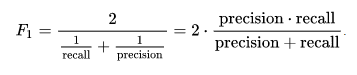


#### Recall
Good recall is the abillity to mark as many class C instances as class C. This means that when a model with perfect recall is given a class, the model will be able to identify every actual member of class C as class C. Note, this does not mean that all instances marked as Class C are indeed class C, just that those that are class C are marked class C. Thus, this metric is concerned with reducing false negatives. 

In our case, recall is the ability for our model to be able to identity all good cars as good or all unacceptable cars as unacceptable (and so on and so forth). A high recall on Very good for example would meean that any instance that is very good will be marked as good. It does not guaruntee that all cars marked as very good are indeed very good. 


#### Precision
Precision is the ability for a model to be correct when it denotes a class as a certain class. This means that a model with high precision on a certain class will be accurate when it says a test case is of that class. A model with perfect precision on that class will allow the user to know that if that class was identified as class c, it is class c. There is however no guartuntee that the model will catch all the class c's in the test set - that is what recall is for. Thus, this metric is concerned with reducing false positives. 

In our case, precision is the abillity for the model to be correct when it labels a car as very good for example. This metric is not concerned with whether or not we capture all the good cars, but with our ability to only cars very good if they are indeed very good.

### Aditional Customization: 

The F1 score is calculated for every class, and then our version takes a macro average accross the classes. For our business case however, we notice that there are classes that are more important than others to improve recall and precision on. These classes are: Unacceptable (unacc), Very Good (vgood). The reason is beacuse firstly, consumers are most interested in the best of cars, and the most losses come to a company from making totally unacceptable cars. And judging by our dataset, where most cars are unacceptable, it is important to make sure that manufacturers avoid creating these cars. 

Furthermore, it is more important that the cars they do end up making are in fact very good, as opposed to seeing a good car as unacceptable. The reason being once again associated with the fixed costs and time associated with manufacturing a bad car vs. missing a good car. One way to create good weigths for this would be to see what is worse, missing a good car or creating a bad car. Generally, creating a bad car is worse because of the reputaion costs and fixed costs associated with it. 

A good ratio may be to weight F1 by class based upon how manufacturer profits respond to missed opportunities or wasted resources. If we had the data to determine the exact ratio of these economic losses it would help us explain a better F1 ratio. However, given most of this is private information we will estimate this ratio.


Thus, we applied weights to the F1 scores by class. These weigths are:</br>
<br>
<br>
Class: unacc, acc, good, vgood
<br>
Weigths: [1.5,1.0,2.0,2.5]

### Final Evaluation Metric:

Thus, our final evaluation metric is an F1 score with classes: [unacc, acc, good, vgood] weighted by scaling factors of [1.5,1.0,2.0,2.5].





## Cross Validation

For our cross validation method we needed to find a data splitting method that will result in train sets that best mirror what manufacturers will have when they have this model in deployment. To do this we need to first understand 

<b><br>
1) How manufacturers will use this model
<br>
2) What is the best cross validation method for that goal
</b>

### Manufacturers

When in deployment the main objective for car manufacturers will be to use this dataset to find what features will make their car acceptable. Generally in a car market there are market leaders and other cars that are not as succesful. This is one reason why in our set the majority of cars are labeled as unacceptable. Manufacturers would like to have these leaders in their set to be able to see what the succesful cars are doing. This means that if we could include the top cars in every set we would most likely be better off. 

Moreover, many manufacturers have a niche of cars that they sell. For example, Jeep would most likly want to know what makes adventurous cars acceptable vs. what makes luxury cars acceptable. What this means is that manufacturers will find a subset of cars to add to their training set and then each manufacturer would use that set to train the model. This means that there may be a huge variance in sets that each manufacturer uses. What this means for us is that if we could subset the data by type of car we would be able to offer the manufacturers a better model. Our data set does not have this data, so we will have to approximate it. 

In conclusion, based on manufacturer needs, we will need to be able to create training sets that include top cars as much as possible, and we need to create training sets that do not all look the same. An ideal scenario would be to divide each set by type of car and competing cars, but because our dataset does not have this data, we will need to create sets with variance to match the variance in manufacturer needs. An additional need for our set is to reduce overfitting as much as possible (ubiquitous for ML models). 

### Method

Given our goals, we narrowed our method down to a standard shuffle split. We were choosing between stratified k-fold and shuffle split and had to weigh their pros and cons in relation to our business case. 

First off, with stratified K-fold, it ensures that every data-point is used once, and it creates sets without overlap that are each microcausms of the full set. his method helps with reducing the overfitting of our model, and stratification helps take care of the issues our class imbalance can cause. This method however does not fare well when it comes to meeting the goals we set for our business case. Firstly, cross validation only allows us to use each point once. This does not match our need that the car market tends to have market leaders that should always be included. Secondly, we are making each set relativly similar in composition through stratification. This helps fight our large class imbalance, but doesn't account for the fact that manufacturers have varied needs and their may be variance is data set population by manufacturer. 

Given these shortcomings, we chose to use a standard shuffle split. Our dataset is large enough that we do not need to worry to much about creating radically odd training sets, but small enough that we can expect variance in our sets. It is the training set variance in this method which is pushing us to use it. As we mentioned above, car manufacturers will all have their own data population, and since we can't create sets to match each manufacturer, the best we can do is to create sets that have variance. Moreover, this method allows for reusing data points, so this method at least allows for the chance of top cars to be recycled in the sets.

Therefore, we will be using a standard shuffle split (train_test_split) to create our training and testing sets. 

### Method Description

For our data split, we will be using the simple built-in train_test_split, with a test_size of 0.1, or 10% of the data.
As shown below, a stratified 10-fold cross validation gives us an accuracy around 70%, essentially the same as what we get through the simple shuffled split, perhaps slightly less accurate.

In [19]:
%%time 
accs = np.array([])
skf = StratifiedKFold(n_splits=10)
nn = NLayerPerceptron(**params)
for train_index, test_index in skf.split(X, y_not_binary):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_not_binary[train_index], y_not_binary[test_index]
    nn.fit(X_train, y_train, print_progress=0)
    yhat = nn.predict(X_test)
    accs = np.append(accs, accuracy_score(y_test,yhat))
    print('Test acc:',accuracy_score(y_test,yhat))
print(np.mean(accs))

IndexError: boolean index did not match indexed array along dimension 0; dimension is 11 but corresponding boolean dimension is 10

In [20]:
%%time 
for iteration in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y_not_binary, test_size=0.1, shuffle=True)
    nn = NLayerPerceptron(**params)
    nn.fit(X_train, y_train, print_progress=10)
    yhat = nn.predict(X_test)
    print('Test acc:',accuracy_score(y_test,yhat))

IndexError: boolean index did not match indexed array along dimension 0; dimension is 11 but corresponding boolean dimension is 10

# Multi Layer Perceptron Modeling

In [22]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka

# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.
import numpy as np
from scipy.special import expit
import pandas as pd
import sys

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class NLayerPerceptron(object):
    def __init__(self, n_hidden=30, n_hidden_layers=2,
                 C=0.0, epochs=500, eta=0.001, random_state=None, 
                 cost_function='quadratic', activation_method='sigmoid'):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.n_hidden_layers = n_hidden_layers
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.cost_function = cost_function
        self.activation_method = activation_method
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        Ws = [None]*self.n_hidden_layers
        for i in range(self.n_hidden_layers):
            #if i!=self.n_hidden_layers-1:
            if i==0:
                Wi_num_elems = (self.n_features_ + 1)*self.n_hidden
                Wi = np.random.uniform(-1.0, 1.0,size=Wi_num_elems)
                Wi = Wi.reshape(self.n_hidden, self.n_features_ + 1)
            elif i==self.n_hidden_layers-1:
                Wi_num_elems = (self.n_hidden + 1)*self.n_output_
                Wi = np.random.uniform(-1.0, 1.0,size=Wi_num_elems)
                Wi = Wi.reshape(self.n_output_, self.n_hidden + 1)
            else:
                Wi_num_elems = (self.n_hidden + 1)*self.n_hidden
                Wi = np.random.uniform(-1.0, 1.0,size=Wi_num_elems)
                Wi = Wi.reshape(self.n_hidden, self.n_hidden + 1)
            
            Ws[i] = Wi
        return Ws
    
    #used for relu
    def _sigmoid(self,z):
        return expit(z)
    
    def _activation(self,z):
        if self.activation_method=='sigmoid':
            return expit(z)
        elif self.activation_method=='linear':
            return z
        elif self.activation_method=='relu':
            return np.maximum(0,z.copy())
        elif self.activation_method=='silu':
            return z*expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, Ws):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        meansquaresum = 0
        for Wi in Ws:
            meansquaresum += np.mean(Wi[:, 1:]**2)
        return (lambda_/2.0) * np.sqrt(meansquaresum)
    
    def _cost(self,A3,Y_enc,Ws):
        if self.cost_function=='quadratic':
            return self._quad_cost(A3,Y_enc,Ws)
        elif self.cost_function=='cross':
            return self._cross_cost(A3,Y_enc,Ws)
    
    def _quad_cost(self,A3,Y_enc,Ws):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, Ws)
        return cost + L2_term
    
    def _cross_cost(self,A3,Y_enc,Ws):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, Ws)
        return cost + L2_term
    
    def _feedforward(self, X, Ws):
        """Compute feedforward step
        """
        As = [None]*(self.n_hidden_layers+1)
        Zs = [None]*self.n_hidden_layers
        for i in range(len(As)):
            if i==0:
                As[0] = self._add_bias_unit(X, how='column')
                As[0] = As[0].T
            else:
                Zs[i-1] = Ws[i-1] @ As[i-1]
                if i!=len(As)-1:
                    As[i] = self._activation(Zs[i-1])
                    As[i] = self._add_bias_unit(As[i], how='row')
                else:
                    As[i] = self._sigmoid(Zs[i-1])

        return As, Zs
    
    def _get_gradient(self, As, Zs, Y_enc, Ws):
        if self.cost_function=='quadratic':
            return self._quad_gradient(As,Zs,Y_enc,Ws)
        elif self.cost_function=='cross':
            return self._cross_gradient(As,Zs,Y_enc,Ws)
        
    
    def _quad_gradient(self, As, Zs, Y_enc, Ws):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        Vs = [None]*self.n_hidden_layers
        grads = [None]*self.n_hidden_layers
        for i in range(self.n_hidden_layers,0,-1):
            if i==self.n_hidden_layers:
                Vs[i-1] = -2*(Y_enc-As[i])*As[i]*(1-As[i])
                grads[i-1] = Vs[i-1] @ As[i-1].T
            elif self.n_hidden_layers > 2 and i <= self.n_hidden_layers - 2 and i > 0:
                if self.activation_method == 'sigmoid':
                    Vs[i-1] = As[i]*(1-As[i])*(Ws[i].T @ Vs[i][1:,:])
                elif self.activation_method == 'linear':
                    Vs[i-1] = (Ws[i].T @ Vs[i][1:,:])
                elif self.activation_method == 'relu':
                    Vs[i-1] = Ws[i].T @ Vs[i][1:,:]
                    Vs[i-1][Zs[i-1]<=0] = 0 
#                 elif self.activation_method == 'silu':
#                     temp = self._sigmoid(Zs[i])*((1-As[i]))
#                     temp2= (As[i] + temp)
#                     Vs[i-1] = Ws[i].T @ Vs[i][1:,:] * temp2
                    
                grads[i-1] = Vs[i-1][1:,:] @ As[i-1].T
            else:
                if self.activation_method == 'sigmoid':
                    Vs[i-1] = As[i]*(1-As[i])*(Ws[i].T @ Vs[i])
                elif self.activation_method == 'linear':
                    Vs[i-1] = (Ws[i].T @ Vs[i])
                elif self.activation_method == 'relu':
                    Vs[i-1] = Ws[i].T @ Vs[i]
                    Vs[i-1][Zs[i-1]<=0] = 0 
#                 elif self.activation_method == 'silu':
#                     temp = self._sigmoid(Zs[i])*((1-As[i]))
#                     temp2 = (As[i] + temp)
#                     Vs[i-1] = Ws[i].T @ Vs[i] * temp2
                grads[i-1] = Vs[i-1][1:,:] @ As[i-1].T
        
        return grads

    
    def _cross_gradient(self, As, Zs, Y_enc, Ws):
        """ Compute gradient step using backpropagation.
        """
        
        Vs = [None]*self.n_hidden_layers
        grads = [None]*self.n_hidden_layers
        for i in range(self.n_hidden_layers,0,-1):
            if i==self.n_hidden_layers:
                Vs[i-1] = As[i]-Y_enc
                grads[i-1] = Vs[i-1] @ As[i-1].T
            elif self.n_hidden_layers > 2 and i <= self.n_hidden_layers - 2 and i > 0:
                if self.activation_method == 'sigmoid':
                    Vs[i-1] = As[i]*(1-As[i])*(Ws[i].T @ Vs[i][1:,:])
                elif self.activation_method == 'linear':
                    Vs[i-1] = (Ws[i].T @ Vs[i][1:,:])
                elif self.activation_method == 'relu':
                    Vs[i-1] = Ws[i].T @ Vs[i][1:,:]
                    Vs[i-1][Zs[i-1]<=0] = 0 
#                 elif self.activation_method == 'silu':
#                     Vs[i-1] = Ws[i].T @ Vs[i][1:,:] * (As[i] + (1-As[i])*self._sigmoid(Zs[i]))
                grads[i-1] = Vs[i-1][1:,:] @ As[i-1].T
            else:
                if self.activation_method == 'sigmoid':
                    Vs[i-1] = As[i]*(1-As[i])*(Ws[i].T @ Vs[i])
                elif self.activation_method == 'linear':
                    Vs[i-1] = (Ws[i].T @ Vs[i])
                elif self.activation_method == 'relu':
                    Vs[i-1] = Ws[i].T @ Vs[i]
                    Vs[i-1][Zs[i-1]<=0] = 0 
#                 elif self.activation_method == 'silu':
#                     Vs[i-1] = Ws[i].T @ Vs[i] * (As[i] + (1-As[i])*self._sigmoid(Zs[i]))
                grads[i-1] = Vs[i-1][1:,:] @ As[i-1].T
        
        return grads
        
    
    def predict(self, X):
        """Predict class labels"""
        As,_ = self._feedforward(X, self.Ws)
        y_pred = np.argmax(As[-1], axis=0)
        return y_pred

    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.Ws = self._initialize_weights()
        #gradients holds the gradients at each layer and iteration, but does not correctly separate them for some reason
        gradients = [[]]*self.n_hidden_layers
        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            As, Zs = self._feedforward(X_data,self.Ws)
            
            cost = self._cost(As[-1],Y_enc,self.Ws)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            grads = self._get_gradient(As=As, Zs=Zs, Y_enc=Y_enc,
                                              Ws=self.Ws)
            
            for j in range(len(self.Ws)):
                self.Ws[j] -= self.eta * grads[j]
                #append to gradients array (does not correctly split, so needs extra work )
                gradients[j].append(np.mean(grads[j]))
        self.gradients_=[]
        for i in range(self.n_hidden_layers):
            self.gradients_.append(gradients[0][i:][::self.n_hidden_layers])
                
            

        return self

In [12]:
params = dict(n_hidden=10, 
              n_hidden_layers=4,
              C=0.1, # tradeoff L2 regularizer
              epochs=500, # iterations
              eta=0.001,  # learning rate
              random_state=1,
              cost_function='quadratic',
              activation_method='relu')

In [18]:
%%time 
nn = NLayerPerceptron(**params)
nn.fit(X_train, y_train, print_progress=10)
yhat = nn.predict(X_test)
print('Test acc:',accuracy_score(y_test,yhat))
sample_weights = [1.5,1.0,2.0,2.5]
weights = [sample_weights[x] for x in y_test ]
print('F1 acc: ', f1_score(y_test,yhat,average='weighted', sample_weight=weights) )

IndexError: boolean index did not match indexed array along dimension 0; dimension is 11 but corresponding boolean dimension is 10

## Hyper-parameter tuning

To tune the hyper-parameters of cost function, activation method and number of layers, we used our evaluation criteria of the F1 score with sample weights of [1.5,1.0,2.0,2.5] for each of the classes and the train_test_split that we found to do a better job than a Stratified KFold. The advantage of using a simple train_test_split is that it drives the number of models we need to build down by a factor of how many folds we decide to have in our KFold. The other parameters, such as neurons to train for each layer, C, number of iterations and learning rate were kept constant across this tuning. It is important to note that they could also have an effect on our performance, but due to the high number of models that needed to be trained already and the lack of high-end equipment, we decided to keep those constant.

In [23]:
cost_functions = ['quadratic', 'cross']
activation_functions = ['sigmoid','linear', 'relu']
num_hidden_layers= [x for x in range(2,8)]
skf = StratifiedKFold(n_splits=10)
results = []
for cost in cost_functions:
    for activation in activation_functions:
        for num in num_hidden_layers:
            params = dict(n_hidden=30, 
              n_hidden_layers=num,
              C=0.1, # tradeoff L2 regularizer
              epochs=500, # iterations
              eta=0.001,  # learning rate
              random_state=1,
              cost_function=cost,
              activation_method=activation)
            nn = NLayerPerceptron(**params)
            nn.fit(X_train, y_train)
            yhat = nn.predict(X_test)
            f1score = f1_score(y_test,yhat,average='weighted', sample_weight=weights)
            acc = accuracy_score(y_test,yhat)
            print("Cost:", cost, "| Activation:", activation, "| Layers:", num, "| F1 Score:", f1score, "| Accuracy:", acc )
            results.append({'cost':cost, 'activation':activation, 'layers':num, 'f1_score':f1score, 'accuracy':acc})

NameError: name 'f1_score' is not defined

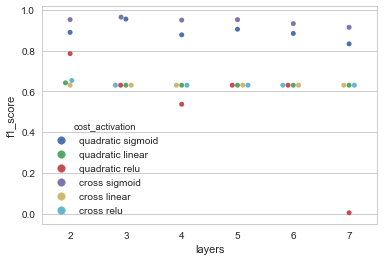

In [805]:
import seaborn as sns
%matplotlib inline
df = pd.DataFrame(results)
df['f1_score']= df['f1_score'].astype(np.float64)
df['cost_activation']=df['cost'] + " "+ df['activation'] 
sns.swarmplot(data=df, y='f1_score',x='layers', hue='cost_activation')

We can see from the graph above that the sigmoid activation function performs significantly better than all other activation functions for our dataset. We can also notice that adding more hidden layers does not improve our performance. In general the cross entropy cost function yields better results for a sigmoid activation function ,while the same is not necessarily true for ReLu at lower number of layers. As the number of layers grows, the accuracy of ReLu or Linear activation does not seem to be affected. Since the functions are very similar for their values over 0, we can assume that the majority of values generated do not go under 0 for more than 3 layers, since the performance is nearly identical for both cost functions with those activation methods. The best model to use out of the 36 tested appears to be between Quadratic Sigmoid with 3 layers and Cross Sigmoid with 3 layers. Due to the fact that for all other layers the sigmoid activation performs much better with a cross entropy cost function, compared to the quadratic cost function, we can conclude it is better fit for our data. Thus, we can conclude that a Cross Sigmoid with 3 layers is the best combination of hyper-parameters to use.

## Gradient magnitude visualization

In [818]:
params = dict(n_hidden=30, 
              n_hidden_layers=3,
              C=0.1, # tradeoff L2 regularizer
              epochs=500, # iterations
              eta=0.001,  # learning rate
              random_state=1,
              cost_function='cross',
              activation_method='sigmoid')

In [819]:
%%time 
nn = NLayerPerceptron(**params)
nn.fit(X_train, y_train, print_progress=10)
yhat = nn.predict(X_test)
print('Test acc:',accuracy_score(y_test,yhat))
sample_weights = [1.5,1.0,2.0,2.5]
weights = [sample_weights[x] for x in y_test ]
print('F1 acc: ', f1_score(y_test,yhat,average='weighted', sample_weight=weights) )

Epoch: 500/500

Test acc: 0.956647398844
F1 acc:  0.964770093822
Wall time: 1.65 s


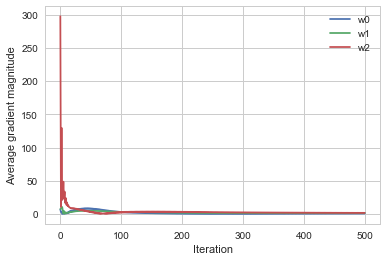

In [820]:
ax = plt.subplot(1,1,1)
for i in range(0,params['n_hidden_layers']):
#     print(nn.gradients_[i])
    plt.plot(np.abs(nn.gradients_[i]), label='w' + str(i) )
plt.legend()
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()

The above plot shows the average magnitutde of the gradients against the training iteration for our best performing model using 3 hidden layers, the cross entropy cost function and the sigmoid activation function. With these hyper-parameters, we can see that the gradients in the outer layer (w2) converge very fast to 0, and we can see that after the 100th iteration, the gradients in all 3 layers are very close to one another in terms of mean value. The gradients seem to stay fairly consistent and the plot does not contain any value spikes.